# 데이터 전처리 및 split

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import calendar
%matplotlib inline

data_df = pd.read_csv('./train.csv')
d_data=data_df['신고일자']
date=[]
for i in range(len(d_data)):
    month=int(d_data[i][5:7])
    year=int(d_data[i][:4])
    day=int(d_data[i][-2:])
    if calendar.weekday(year,month,day)==0:
        date.append('Mon')
    elif calendar.weekday(year,month,day)==1:
        date.append('Tue')
    elif calendar.weekday(year,month,day)==2:
        date.append('Wed')
    elif calendar.weekday(year,month,day)==3:
        date.append('Thu')
    elif calendar.weekday(year,month,day)==4:
        date.append('Fri')
    elif calendar.weekday(year,month,day)==5:
        date.append('Sat')
    elif calendar.weekday(year,month,day)==6:
        date.append('Sun')
data_df['신고일자(요일)']=date

#반입보세구역부호_with 미정구역
bose = []
for i in range(89619):
    ekey = str(data_df["반입보세구역부호"].iloc[i])
    if ekey[-5:]=='99999':
        bose.append(30000)
    elif len(ekey)==8:
        bose.append(int(ekey[:5]))
    elif len(ekey)==7:
        bose.append(int(ekey[:4]))
    elif len(ekey)==6:
        bose.append(int(ekey[:3]))
    elif len(ekey)==5:
        bose.append(0)

data_df = data_df.drop("반입보세구역부호", axis = 1)
data_df["반입보세구역부호"] = bose

# 해외거래처
dic3 = {}
for i in range(89619):
    ekey = data_df["해외거래처부호"].iloc[i]
    if ekey in dic3.keys():
        dic3[ekey] += 1
    else:
        dic3[ekey] = 1
        
summ = 0
for key in list(dic3.keys()):
    summ += dic3[key]
print(summ, len(list(dic3.keys())))

partner = []
for i in range(89619):
    ekey = data_df["해외거래처부호"].iloc[i]
    if ekey in dic3.keys():
        partner.append(ekey)
    else:
        partner.append(np.NaN)
partnerkey = list(dic3.keys())
data_df = data_df.drop("해외거래처부호", axis = 1)
data_df["해외거래처부호"] = partner

#신고인부호
report = []
for i in range(89619):
    ekey = str(data_df["신고인부호"].iloc[i])[0]
    report.append(ekey)
data_df = data_df.drop("신고인부호", axis = 1)
data_df["신고인부호"] = report

# 화주
dic4 = {}
for i in range(89619):
    ekey = data_df["수입자부호"].iloc[i]
    if ekey in dic4.keys():
        dic4[ekey] += 1
    else:
        dic4[ekey] = 1
        
summ = 0
for key in list(dic4.keys()):
    summ += dic4[key]
ownerkey = list(dic4.keys())
print(summ, len(list(dic4.keys())))

partner = []
for i in range(89619):
    ekey = data_df["수입자부호"].iloc[i]
    if ekey in dic4.keys():
        partner.append(ekey)
    else:
        partner.append(np.NaN)

data_df = data_df.drop("수입자부호", axis = 1)
data_df["수입자부호"] = partner

#적출산지
dic5 = {}
for i in range(89619):
    ekey = str(data_df["적출국가코드"].iloc[i])
    nkey = str(data_df["원산지국가코드"].iloc[i])
    totalkey = ekey + '-' + nkey
    if totalkey in dic5.keys():
        dic5[totalkey] += 1
    else:
        dic5[totalkey] = 1

shiporiginalkey = list(dic5.keys())

total_country = []
for i in range(89619):
    ekey = str(data_df["적출국가코드"].iloc[i])
    nkey = str(data_df["원산지국가코드"].iloc[i])
    totalkey = ekey + '-' + nkey
    if totalkey in dic5.keys():
        total_country.append(totalkey)
    else:
        total_country.append(np.NaN)

data_df = data_df.drop(['적출국가코드', '원산지국가코드'], axis = 1)
data_df['적출-원산지'] = total_country


# hs 10 바꾸고 승우의 신고인 부호 앞자리 넣어서 돌려보기, hs 10은 소 중 대 가 쓸모있는 distribution을 보임
data_df_hscode = pd.read_csv('./관세청_HSK별 표준품명.csv', encoding = 'CP949')
hs_dic = {}
for i in range(12243):
    hs_dic[data_df_hscode["HS CODE 10"].iloc[i]] = [
        data_df_hscode['관세청 신성질별 분류대분류명'].iloc[i],
        data_df_hscode['관세청 신성질별 분류중분류명'].iloc[i],
        data_df_hscode['관세청 신성질별 분류소분류명'].iloc[i],
        data_df_hscode['관세청 신성질별 분류세분류명'].iloc[i],
        data_df_hscode['관세청 신성질별 분류세세분류명'].iloc[i]
        #분류세분류코드 나중에는 넣기
    ]
    
hs10_mid = []
for i in range(89619):
    ekey = data_df["HS10단위부호"].iloc[i]
    hs10_mid.append((hs_dic[ekey])[2])

data_df = data_df.drop("HS10단위부호", axis = 1)
data_df["HS10단위부호_중"] = hs10_mid

from sklearn.preprocessing import MinMaxScaler

#신고중량
scaler_1 = MinMaxScaler()
changed_reportKG = data_df['신고중량(KG)'].round(0).astype(int)
log_reportKG = np.log1p(changed_reportKG)
log_reportKG = np.array(log_reportKG).reshape(-1, 1)
scaler_1.fit(log_reportKG)
log_reportKG = scaler_1.transform(log_reportKG)

data_df = data_df.drop("신고중량(KG)", axis = 1)
data_df['신고중량(KG)'] = log_reportKG

#과세가격원화금액
scaler_2 = MinMaxScaler()
changed_wonmoney = data_df['과세가격원화금액'].round(0).astype(int)
log_wonmoney = np.log1p(changed_wonmoney)
log_wonmoney = np.array(log_wonmoney).reshape(-1, 1)
scaler_2.fit(log_wonmoney)
log_wonmoney = scaler_2.transform(log_wonmoney)

data_df = data_df.drop("과세가격원화금액", axis = 1)
data_df['과세가격원화금액'] = log_wonmoney

data_df.head(10)

89619 4644
89619 8429


C:\Users\LastDefiance\anaconda3\envs\ssu\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


,신고번호,신고일자,통관지세관부호,특송업체부호,수입통관계획코드,수입신고구분코드,수입거래구분코드,수입종류코드,징수형태코드,운송수단유형코드,...,핵심적발,신고일자(요일),반입보세구역부호,해외거래처부호,신고인부호,수입자부호,적출-원산지,HS10단위부호_중,신고중량(KG),과세가격원화금액
0,37453,2020-01-01,40,NaN,C,A,15,21,11,40,...,0,Wed,4077,CFLCEFM,1,435E04J,CN-CN,4)가방류,0.659121,0.438090
1,150339,2020-01-01,20,NaN,C,B,15,21,11,10,...,0,Wed,4002,NaN,7,1NTJ7F6,CN-CN,4)내구성 생활용품,0.714782,0.619642
2,55710,2020-01-01,10,8W5SEL,F,B,94,21,11,40,...,2,Wed,15002,ZEXKR7K,Q,DGHPNRA,CN-CN,6)수송장비 부품,0.415202,0.514617
3,413154,2020-01-01,20,0X6YQV,C,B,15,21,11,10,...,0,Wed,4002,WD62ULK,S,G85A4OI,CN-CN,3)화합물,0.664183,0.712146
4,223511,2020-01-01,40,NaN,F,B,15,21,11,10,...,0,Wed,2002,Q22MMTW,B,9I00BFP,CN-CN,2)의류,0.666654,0.652896
5,149750,2020-01-01,20,2TNP07,C,B,11,21,21,10,...,0,Wed,13106,HWI9WCT,H,J0HY67G,CN-KR,3)화합물,0.593987,0.739492
6,66465,2020-01-01,20,NaN,C,B,11,21,11,10,...,0,Wed,2006,Q6Q3KNY,S,ADCWHI1,CN-CN,4)내구성 생활용품,0.689787,0.468708
7,449617,2020-01-01,20,NaN,F,B,15,21,11,40,...,0,Wed,2012,TD6B09E,0,WA705JJ,CA-CA,4)조제식료품,0.616487,0.455402
8,482487,2020-01-01,62,22DM56,C,B,11,21,11,30,...,0,Wed,2006,RSV1PP4,K,9PO679D,DE-DE,3)일반기계,0.616080,0.539354
9,468660,2020-01-01,13,NaN,D,B,11,21,43,10,...,0,Wed,2006,NaN,Z,5AI5841,IT-IT,4)가방류,0.608712,0.613337


In [2]:
data_df_train = data_df.drop(["핵심적발", "신고번호", "신고일자"], axis = 1)

data_df_train.rename(columns = {
                    '신고인부호': 'reporter',
                    '수입자부호': 'box_owner',
                    '해외거래처부호': 'oversea_partner',
                    '통관지세관부호': 'taxing_place',
                    '특송업체부호': 'shipping_company',
                    '수입통관계획코드': 'import_clearance_code',
                    '수입신고구분코드': 'import_declaration_code',
                    '수입거래구분코드': 'import_transaction_code',
                    '수입종류코드': 'import_category_code',
                    '징수형태코드': 'collection_form_code',
                    '신고중량(KG)': 'weight(KG)',
                    '과세가격원화금액': 'taxable_value_won',
                    '운송수단유형코드': 'shpping_transportation',
                    '반입보세구역부호': 'import_bonded_area',
                    '관세율구분코드': 'tax_division_code',
                    '관세율': 'tax_rate',
                    '우범여부': 'ubum_target',
                    '신고일자(요일)': 'week_day',
                    'HS10단위부호_중': 'HS10',
                    '적출-원산지': 'ship-original_country'
                    }, inplace = True)

print(data_df_train.shape)
data_df_train.head(10)

(89619, 20)


,taxing_place,shipping_company,import_clearance_code,import_declaration_code,import_transaction_code,import_category_code,collection_form_code,shpping_transportation,tax_division_code,tax_rate,ubum_target,week_day,import_bonded_area,oversea_partner,reporter,box_owner,ship-original_country,HS10,weight(KG),taxable_value_won
0,40,NaN,C,A,15,21,11,40,A,8.0,0,Wed,4077,CFLCEFM,1,435E04J,CN-CN,4)가방류,0.659121,0.438090
1,20,NaN,C,B,15,21,11,10,A,8.0,0,Wed,4002,NaN,7,1NTJ7F6,CN-CN,4)내구성 생활용품,0.714782,0.619642
2,10,8W5SEL,F,B,94,21,11,40,FCN1,3.2,1,Wed,15002,ZEXKR7K,Q,DGHPNRA,CN-CN,6)수송장비 부품,0.415202,0.514617
3,20,0X6YQV,C,B,15,21,11,10,FCN1,0.0,0,Wed,4002,WD62ULK,S,G85A4OI,CN-CN,3)화합물,0.664183,0.712146
4,40,NaN,F,B,15,21,11,10,A,13.0,0,Wed,2002,Q22MMTW,B,9I00BFP,CN-CN,2)의류,0.666654,0.652896
5,20,2TNP07,C,B,11,21,21,10,C,5.5,0,Wed,13106,HWI9WCT,H,J0HY67G,CN-KR,3)화합물,0.593987,0.739492
6,20,NaN,C,B,11,21,11,10,FCN1,0.0,0,Wed,2006,Q6Q3KNY,S,ADCWHI1,CN-CN,4)내구성 생활용품,0.689787,0.468708
7,20,NaN,F,B,15,21,11,40,A,8.0,0,Wed,2012,TD6B09E,0,WA705JJ,CA-CA,4)조제식료품,0.616487,0.455402
8,62,22DM56,C,B,11,21,11,30,FEU1,0.0,0,Wed,2006,RSV1PP4,K,9PO679D,DE-DE,3)일반기계,0.616080,0.539354
9,13,NaN,D,B,11,21,43,10,FEU1,0.0,0,Wed,2006,NaN,Z,5AI5841,IT-IT,4)가방류,0.608712,0.613337


In [3]:
data_df2 = pd.read_csv('./test.csv')
print(data_df2.shape)
data_df2.head(10)

(10273, 21)


,신고번호,신고일자,통관지세관부호,신고인부호,수입자부호,해외거래처부호,특송업체부호,수입통관계획코드,수입신고구분코드,수입거래구분코드,...,징수형태코드,신고중량(KG),과세가격원화금액,운송수단유형코드,반입보세구역부호,HS10단위부호,적출국가코드,원산지국가코드,관세율구분코드,관세율
0,982834,2020-11-23,20,KWGEB,B7FVPTT,0TSA7K7,NaN,F,B,15,...,11,3731.9,2.755287e+06,40,3012343,712909000,US,US,A,27.0
1,828961,2020-11-23,40,6KGOC,5O4D6XE,NaN,NaN,E,B,94,...,11,6406.5,8.517864e+05,40,4077106,9703001000,US,US,A,0.0
2,522066,2020-11-23,40,F8UY6,X71K5VO,NaN,NaN,C,B,11,...,11,5824.9,6.532926e+04,40,4002001,2106909099,US,US,A,8.0
3,999547,2020-11-23,16,IK9DK,VOA8M3S,NaN,NaN,C,B,11,...,11,3798.3,1.028587e+06,40,2011007,1207999000,US,US,A,3.0
4,919320,2020-11-23,10,R716N,205JY8P,NaN,NaN,C,B,11,...,11,3795.7,1.677178e+06,40,1011182,8711201000,VN,VN,FVN1,0.0
5,792304,2020-11-23,40,P15QT,IFZQ0YC,NaN,NaN,C,B,11,...,11,4207.7,2.280649e+05,10,3077013,5806103000,CN,CN,A,8.0
6,778082,2020-11-23,20,964CV,D4BNSRC,NaN,NaN,F,B,94,...,11,4196.3,4.038626e+05,40,2006099,3304991000,JP,JP,C,6.5
7,624568,2020-11-23,40,GLXVJ,GVOUVBL,YOJCGGQ,NaN,D,B,11,...,11,40489.6,0.000000e+00,40,4077009,3915909000,JP,JP,C,6.5
8,649243,2020-11-23,40,MS6NT,3UX0X12,BH4PKJM,NaN,D,B,11,...,11,2871.0,1.078967e+06,40,1602003,3907202000,CN,CN,FCN1,3.9
9,834543,2020-11-23,40,FB5QA,X71K5VO,NaN,NaN,C,B,11,...,11,2597.5,2.913230e+04,40,4077063,2106909099,CN,CN,A,8.0


In [4]:
d_data=data_df2['신고일자']
date=[]
for i in range(len(d_data)):
    month=int(d_data[i][5:7])
    year=int(d_data[i][:4])
    day=int(d_data[i][-2:])
    if calendar.weekday(year,month,day)==0:
        date.append('Mon')
    elif calendar.weekday(year,month,day)==1:
        date.append('Tue')
    elif calendar.weekday(year,month,day)==2:
        date.append('Wed')
    elif calendar.weekday(year,month,day)==3:
        date.append('Thu')
    elif calendar.weekday(year,month,day)==4:
        date.append('Fri')
    elif calendar.weekday(year,month,day)==5:
        date.append('Sat')
    elif calendar.weekday(year,month,day)==6:
        date.append('Sun')
data_df2['신고일자(요일)']=date

#반입보세구역부호_with 미정구역
bose = []
for i in range(10273):
    ekey = str(data_df2["반입보세구역부호"].iloc[i])
    if ekey[-5:]=='99999':
        bose.append(int(30000))
    elif len(ekey)==8:
        bose.append(int(ekey[:5]))
    elif len(ekey)==7:
        bose.append(int(ekey[:4]))
    elif len(ekey)==6:
        bose.append(int(ekey[:3]))
    elif len(ekey)==5:
        bose.append(0)

data_df2 = data_df2.drop("반입보세구역부호", axis = 1)
data_df2["반입보세구역부호"] = bose

# 해외거래처
dic3 = {}
for i in range(10273):
    ekey = data_df2["해외거래처부호"].iloc[i]
    if ekey in dic3.keys():
        dic3[ekey] += 1
    else:
        dic3[ekey] = 1
        
summ = 0
for key in list(dic3.keys()):
    summ += dic3[key]
print(summ, len(list(dic3.keys())))

partner = []
for i in range(10273):
    ekey = data_df2["해외거래처부호"].iloc[i]
    if ekey in dic3.keys():
        partner.append(ekey)
    else:
        partner.append(np.NaN)
partnerkey_3 = list(dic3.keys())
data_df2 = data_df2.drop("해외거래처부호", axis = 1)
data_df2["해외거래처부호"] = partner

#신고인부호
report = []
for i in range(10273):
    ekey = str(data_df2["신고인부호"].iloc[i])[0]
    report.append(ekey)
data_df2 = data_df2.drop("신고인부호", axis = 1)
data_df2["신고인부호"] = report

# 화주
dic4 = {}
for i in range(10273):
    ekey = data_df2["수입자부호"].iloc[i]
    if ekey in dic4.keys():
        dic4[ekey] += 1
    else:
        dic4[ekey] = 1
        
summ = 0
for key in list(dic4.keys()):
    summ += dic4[key]
ownerkey_3 = list(dic4.keys())
print(summ, len(list(dic4.keys())))

partner = []
for i in range(10273):
    ekey = data_df2["수입자부호"].iloc[i]
    if ekey in dic4.keys():
        partner.append(ekey)
    else:
        partner.append(np.NaN)

data_df2 = data_df2.drop("수입자부호", axis = 1)
data_df2["수입자부호"] = partner

#적출산지
dic5 = {}
for i in range(10273):
    ekey = str(data_df2["적출국가코드"].iloc[i])
    nkey = str(data_df2["원산지국가코드"].iloc[i])
    totalkey = ekey + '-' + nkey
    if totalkey in dic5.keys():
        dic5[totalkey] += 1
    else:
        dic5[totalkey] = 1

shiporiginalkey_3 = list(dic5.keys())

total_country = []
for i in range(10273):
    ekey = str(data_df2["적출국가코드"].iloc[i])
    nkey = str(data_df2["원산지국가코드"].iloc[i])
    totalkey = ekey + '-' + nkey
    if totalkey in dic5.keys():
        total_country.append(totalkey)
    else:
        total_country.append(np.NaN)

data_df2 = data_df2.drop("적출국가코드", axis = 1)
data_df2 = data_df2.drop("원산지국가코드", axis = 1)
data_df2['적출-원산지'] = total_country


# hs 10 바꾸고 승우의 신고인 부호 앞자리 넣어서 돌려보기, hs 10은 소 중 대 가 쓸모있는 distribution을 보임
data_df_hscode = pd.read_csv('./관세청_HSK별 표준품명.csv', encoding = 'CP949')
hs_dic = {}
for i in range(12243):
    hs_dic[data_df_hscode["HS CODE 10"].iloc[i]] = [
        data_df_hscode['관세청 신성질별 분류대분류명'].iloc[i],
        data_df_hscode['관세청 신성질별 분류중분류명'].iloc[i],
        data_df_hscode['관세청 신성질별 분류소분류명'].iloc[i],
        data_df_hscode['관세청 신성질별 분류세분류명'].iloc[i],
        data_df_hscode['관세청 신성질별 분류세세분류명'].iloc[i]
        #분류세분류코드 나중에는 넣기
    ]
    
hs10_mid = []
for i in range(10273):
    ekey = data_df2["HS10단위부호"].iloc[i]
    hs10_mid.append((hs_dic[ekey])[2])

data_df2 = data_df2.drop("HS10단위부호", axis = 1)
data_df2["HS10단위부호_중"] = hs10_mid

#신고중량
changed_reportKG = data_df2['신고중량(KG)'].round(0).astype(int)
log_reportKG = np.log1p(changed_reportKG)
log_reportKG = np.array(log_reportKG).reshape(-1, 1)
log_reportKG = scaler_1.transform(log_reportKG)

data_df2 = data_df2.drop("신고중량(KG)", axis = 1)
data_df2['신고중량(KG)'] = log_reportKG

#과세가격원화금액
changed_wonmoney = data_df2['과세가격원화금액'].round(0).astype(int)
log_wonmoney = np.log1p(changed_wonmoney)
log_wonmoney = np.array(log_wonmoney).reshape(-1, 1)
log_wonmoney = scaler_2.transform(log_wonmoney)

data_df2 = data_df2.drop("과세가격원화금액", axis = 1)
data_df2['과세가격원화금액'] = log_wonmoney

data_df2.head(10)

10273 2895
10273 4856


C:\Users\LastDefiance\anaconda3\envs\ssu\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


,신고번호,신고일자,통관지세관부호,특송업체부호,수입통관계획코드,수입신고구분코드,수입거래구분코드,수입종류코드,징수형태코드,운송수단유형코드,...,관세율,신고일자(요일),반입보세구역부호,해외거래처부호,신고인부호,수입자부호,적출-원산지,HS10단위부호_중,신고중량(KG),과세가격원화금액
0,982834,2020-11-23,20,NaN,F,B,15,21,11,40,...,27.0,Mon,3012,0TSA7K7,K,B7FVPTT,US-US,1)농산물(소비재),0.649309,0.691169
1,828961,2020-11-23,40,NaN,E,B,94,21,11,40,...,0.0,Mon,4077,NaN,6,5O4D6XE,US-US,5)예술품·수집품 및 골동품,0.695877,0.636453
2,522066,2020-11-23,40,NaN,C,B,11,21,11,40,...,8.0,Mon,4002,NaN,F,X71K5VO,US-US,4)조제식료품,0.687682,0.516766
3,999547,2020-11-23,16,NaN,C,B,11,21,11,40,...,3.0,Mon,2011,NaN,I,VOA8M3S,US-US,1)농산물(소비재),0.650819,0.645244
4,919320,2020-11-23,10,NaN,C,B,11,21,11,40,...,0.0,Mon,1011,NaN,R,205JY8P,VN-VN,2)자동차,0.650774,0.668032
5,792304,2020-11-23,40,NaN,C,B,11,11,11,10,...,8.0,Mon,3077,NaN,P,IFZQ0YC,CN-CN,3)섬유직물,0.659655,0.575036
6,778082,2020-11-23,20,NaN,F,B,94,21,11,40,...,6.5,Mon,2006,NaN,9,D4BNSRC,JP-JP,5)화장품류,0.659409,0.601670
7,624568,2020-11-23,40,NaN,D,B,11,21,11,40,...,6.5,Mon,4077,YOJCGGQ,G,GVOUVBL,JP-JP,5)플라스틱제품,0.854819,0.000000
8,649243,2020-11-23,40,NaN,D,B,11,21,11,40,...,3.9,Mon,1602,BH4PKJM,M,3UX0X12,CN-CN,1)석유화학제품,0.626704,0.647472
9,834543,2020-11-23,40,NaN,C,B,11,21,11,40,...,8.0,Mon,4077,NaN,F,X71K5VO,CN-CN,4)조제식료품,0.618094,0.479125


In [5]:
data_df_test = data_df2.drop(["신고번호", "신고일자"], axis = 1)

data_df_test.rename(columns = {
                    '신고인부호': 'reporter',
                    '수입자부호': 'box_owner',
                    '해외거래처부호': 'oversea_partner',
                    '통관지세관부호': 'taxing_place',
                    '특송업체부호': 'shipping_company',
                    '수입통관계획코드': 'import_clearance_code',
                    '수입신고구분코드': 'import_declaration_code',
                    '수입거래구분코드': 'import_transaction_code',
                    '수입종류코드': 'import_category_code',
                    '징수형태코드': 'collection_form_code',
                    '신고중량(KG)': 'weight(KG)',
                    '과세가격원화금액': 'taxable_value_won',
                    '운송수단유형코드': 'shpping_transportation',
                    '반입보세구역부호': 'import_bonded_area',
                    '관세율구분코드': 'tax_division_code',
                    '관세율': 'tax_rate',
                    '신고일자(요일)': 'week_day',
                    'HS10단위부호_중': 'HS10',
                    '적출-원산지': 'ship-original_country'
                    }, inplace = True)

print(data_df_test.shape)
data_df_test.head(10)

(10273, 19)


,taxing_place,shipping_company,import_clearance_code,import_declaration_code,import_transaction_code,import_category_code,collection_form_code,shpping_transportation,tax_division_code,tax_rate,week_day,import_bonded_area,oversea_partner,reporter,box_owner,ship-original_country,HS10,weight(KG),taxable_value_won
0,20,NaN,F,B,15,21,11,40,A,27.0,Mon,3012,0TSA7K7,K,B7FVPTT,US-US,1)농산물(소비재),0.649309,0.691169
1,40,NaN,E,B,94,21,11,40,A,0.0,Mon,4077,NaN,6,5O4D6XE,US-US,5)예술품·수집품 및 골동품,0.695877,0.636453
2,40,NaN,C,B,11,21,11,40,A,8.0,Mon,4002,NaN,F,X71K5VO,US-US,4)조제식료품,0.687682,0.516766
3,16,NaN,C,B,11,21,11,40,A,3.0,Mon,2011,NaN,I,VOA8M3S,US-US,1)농산물(소비재),0.650819,0.645244
4,10,NaN,C,B,11,21,11,40,FVN1,0.0,Mon,1011,NaN,R,205JY8P,VN-VN,2)자동차,0.650774,0.668032
5,40,NaN,C,B,11,11,11,10,A,8.0,Mon,3077,NaN,P,IFZQ0YC,CN-CN,3)섬유직물,0.659655,0.575036
6,20,NaN,F,B,94,21,11,40,C,6.5,Mon,2006,NaN,9,D4BNSRC,JP-JP,5)화장품류,0.659409,0.601670
7,40,NaN,D,B,11,21,11,40,C,6.5,Mon,4077,YOJCGGQ,G,GVOUVBL,JP-JP,5)플라스틱제품,0.854819,0.000000
8,40,NaN,D,B,11,21,11,40,FCN1,3.9,Mon,1602,BH4PKJM,M,3UX0X12,CN-CN,1)석유화학제품,0.626704,0.647472
9,40,NaN,C,B,11,21,11,40,A,8.0,Mon,4077,NaN,F,X71K5VO,CN-CN,4)조제식료품,0.618094,0.479125


In [6]:
data_df_train = data_df_train.drop(['box_owner', 'oversea_partner', 'tax_rate'], axis = 1)

In [7]:
pleasemean = ['reporter',
              'taxing_place',
                'shipping_company',
                'import_clearance_code',
                'import_declaration_code',
                'import_transaction_code',
                 'import_category_code',
                 'collection_form_code',
                'shpping_transportation',
                'import_bonded_area',
                'tax_division_code',
                'week_day',
                'HS10',
                 'ship-original_country']

data_df_train_mean = data_df_train[:]

data_df_train_original = data_df_train[:]


mean_dic = {}

for ystr in pleasemean:
    mean_encode = data_df_train_mean.groupby(ystr)["ubum_target"].mean()
    print(mean_encode)
    data_df_train_mean[ystr] = data_df_train_mean[ystr].map(mean_encode)
        
    weight = 20
    
    mean = data_df_train_mean[ystr].mean()
    mean_dic[ystr] = mean
    
    print(mean)
    agg = data_df_train_mean.groupby(ystr)["ubum_target"].agg(['count', 'mean'])
    counts = agg['count']
    means = agg['mean']
    smooth = (counts * means + weight * mean) / (counts + weight)
    
    print(smooth)

    data_df_train_mean[ystr] = data_df_train_mean[ystr].map(smooth)

data_df_train_mean.head(10)

reporter
0    0.209763
1    0.221190
2    0.264249
3    0.228287
4    0.264654
5    0.220926
6    0.221832
7    0.264426
8    0.192077
9    0.295576
A    0.184719
B    0.236899
C    0.276827
D    0.290520
E    0.151091
F    0.240183
G    0.213245
H    0.239642
I    0.293651
J    0.264110
K    0.233732
L    0.246314
M    0.223786
N    0.232937
O    0.306847
P    0.301348
Q    0.199565
R    0.167072
S    0.123598
T    0.226659
U    0.236740
V    0.177620
W    0.211013
X    0.237207
Y    0.245325
Z    0.307692
Name: ubum_target, dtype: float64
0.2207456008212079
reporter
0.123598    0.123942
0.151091    0.151368
0.167072    0.167397
0.177620    0.177909
0.184719    0.184939
0.192077    0.192339
0.199565    0.199696
0.209763    0.209824
0.211013    0.211087
0.213245    0.213278
0.220926    0.220925
0.221190    0.221187
0.221832    0.221826
0.223786    0.223758
0.226659    0.226590
0.228287    0.228236
0.232937    0.232861
0.233732    0.233562
0.236740    0.236536
0.236899    0.236670
0.237

week_day
0.197583    0.197603
0.216146    0.216152
0.218806    0.218808
0.220868    0.220867
0.227870    0.227860
0.319478    0.318804
0.354947    0.353463
dtype: float64
HS10
1)가전제품               0.237685
1)광물                 0.254717
1)금속 구조물, 용기 및 무기    0.259259
1)기타 원자재             0.361111
1)농산물(소비재)           0.206173
                       ...   
7)기타 수송장비            0.293578
7)담배                 0.240580
7)제지원료 및 종이류         0.256571
8)고무                 0.220588
9)목재                 0.239631
Name: ubum_target, Length: 63, dtype: float64
0.22074560082120115
HS10
0.130711    0.130964
0.173869    0.174186
0.194553    0.196444
0.198860    0.198984
0.199532    0.199567
              ...   
0.295455    0.287831
0.295522    0.291310
0.295714    0.293632
0.307692    0.254997
0.361111    0.310981
Length: 63, dtype: float64
ship-original_country
AE-AE    0.172222
AE-BE    0.375000
AE-DE    0.500000
AE-ES    0.454545
AE-IN    0.000000
           ...   
VN-US    0.545455
VN-VN    0.251206

,taxing_place,shipping_company,import_clearance_code,import_declaration_code,import_transaction_code,import_category_code,collection_form_code,shpping_transportation,tax_division_code,ubum_target,week_day,import_bonded_area,reporter,ship-original_country,HS10,weight(KG),taxable_value_won
0,0.187533,NaN,0.200934,0.188457,0.240936,0.222002,0.179900,0.229217,0.208862,0,0.220867,0.203214,0.221187,0.218415,0.198984,0.659121,0.438090
1,0.205837,NaN,0.200934,0.213356,0.240936,0.222002,0.179900,0.193467,0.208862,0,0.220867,0.106000,0.263879,0.218415,0.199567,0.714782,0.619642
2,0.124189,0.521020,0.296245,0.213356,0.298017,0.222002,0.179900,0.229217,0.238233,1,0.220867,0.368351,0.199696,0.218415,0.247089,0.415202,0.514617
3,0.205837,0.309626,0.200934,0.213356,0.240936,0.222002,0.179900,0.193467,0.238233,0,0.220867,0.106000,0.123942,0.218415,0.273427,0.664183,0.712146
4,0.187533,NaN,0.296245,0.213356,0.240936,0.222002,0.179900,0.193467,0.208862,0,0.220867,0.126817,0.236670,0.218415,0.243013,0.666654,0.652896
5,0.205837,0.442105,0.200934,0.213356,0.167850,0.222002,0.404048,0.193467,0.211427,0,0.220867,0.368825,0.239466,0.283973,0.273427,0.593987,0.739492
6,0.205837,NaN,0.200934,0.213356,0.167850,0.222002,0.179900,0.193467,0.238233,0,0.220867,0.249934,0.123942,0.218415,0.199567,0.689787,0.468708
7,0.205837,NaN,0.296245,0.213356,0.240936,0.222002,0.179900,0.229217,0.208862,0,0.220867,0.223586,0.209824,0.219713,0.130964,0.616487,0.455402
8,0.485962,0.462684,0.200934,0.213356,0.167850,0.222002,0.179900,0.449563,0.245042,0,0.220867,0.249934,0.233562,0.238619,0.244350,0.616080,0.539354
9,0.365270,NaN,0.209226,0.213356,0.167850,0.222002,0.363484,0.193467,0.245042,0,0.220867,0.249934,0.306592,0.229721,0.198984,0.608712,0.613337


In [8]:
data_df_2 = data_df[(data_df["핵심적발"] != 0)]
data_df_2_mean = data_df_train_mean[(data_df_train_mean["ubum_target"] != 0)]
print(data_df_2.shape, data_df_2_mean.shape)

ubum_result = []
for i in range(19783):
    if data_df_2["핵심적발"].iloc[i] == 1:
        ubum_result.append(0)
    else:
        ubum_result.append(1)

data_df_2 = data_df_2_mean.drop("ubum_target", axis = 1)
data_df_2["important_target"] = ubum_result

data_df_2.head(10)
data_df_train_mean_2 = data_df_2[:]

(19783, 23) (19783, 17)


In [9]:
data_df_train_mean_2.head(10)

,taxing_place,shipping_company,import_clearance_code,import_declaration_code,import_transaction_code,import_category_code,collection_form_code,shpping_transportation,tax_division_code,week_day,import_bonded_area,reporter,ship-original_country,HS10,weight(KG),taxable_value_won,important_target
2,0.124189,0.521020,0.296245,0.213356,0.298017,0.222002,0.179900,0.229217,0.238233,0.220867,0.368351,0.199696,0.218415,0.247089,0.415202,0.514617,1
13,0.187533,0.434513,0.200934,0.213356,0.240936,0.222002,0.363484,0.229217,0.238233,0.220867,0.203214,0.177909,0.218415,0.130964,0.674346,0.609392,0
15,0.239669,0.406413,0.200934,0.213356,0.240936,0.222002,0.179900,0.193467,0.211427,0.220867,0.351645,0.237033,0.245837,0.199567,0.623929,0.567918,0
20,0.365270,NaN,0.209226,0.213356,0.240936,0.222002,0.179900,0.465179,0.211427,0.220867,0.336477,0.236536,0.218415,0.243691,0.758510,0.627030,1
26,0.239669,0.360713,0.296245,0.213356,0.240936,0.222002,0.179900,0.229217,0.238233,0.220867,0.203214,0.289677,0.218415,0.236060,0.611478,0.644681,1
27,0.187533,NaN,0.200934,0.213356,0.298017,0.222002,0.404048,0.465179,0.208862,0.220867,0.184207,0.237033,0.238619,0.247089,0.649147,0.569197,0
28,0.205837,0.309626,0.209226,0.213356,0.513551,0.222002,0.374296,0.229217,0.208862,0.220867,0.249934,0.226590,0.220981,0.247589,0.650797,1.000000,0
30,0.205837,0.309626,0.200934,0.213356,0.368369,0.222002,0.363484,0.193467,0.208862,0.220867,0.331974,0.177909,0.326832,0.259915,0.633955,0.729537,0
33,0.205837,0.309626,0.209226,0.213356,0.240936,0.222002,0.421794,0.193467,0.211427,0.220867,0.244998,0.239466,0.182037,0.208661,0.399972,0.557967,0
35,0.205837,NaN,0.296245,0.213356,0.167850,0.222002,0.179900,0.229217,0.208862,0.220867,0.126817,0.264267,0.220981,0.219779,0.717943,0.722742,1


In [10]:
data_df_test = data_df_test.drop(['box_owner', 'oversea_partner', 'tax_rate'], axis = 1)
data_df_test.head(5)

,taxing_place,shipping_company,import_clearance_code,import_declaration_code,import_transaction_code,import_category_code,collection_form_code,shpping_transportation,tax_division_code,week_day,import_bonded_area,reporter,ship-original_country,HS10,weight(KG),taxable_value_won
0,20,NaN,F,B,15,21,11,40,A,Mon,3012,K,US-US,1)농산물(소비재),0.649309,0.691169
1,40,NaN,E,B,94,21,11,40,A,Mon,4077,6,US-US,5)예술품·수집품 및 골동품,0.695877,0.636453
2,40,NaN,C,B,11,21,11,40,A,Mon,4002,F,US-US,4)조제식료품,0.687682,0.516766
3,16,NaN,C,B,11,21,11,40,A,Mon,2011,I,US-US,1)농산물(소비재),0.650819,0.645244
4,10,NaN,C,B,11,21,11,40,FVN1,Mon,1011,R,VN-VN,2)자동차,0.650774,0.668032


In [11]:
data_df_test_mean = data_df_test[:]

for ystr in pleasemean:
    weight = 20
    
    mean = mean_dic[ystr]
    
    agg = data_df_train_original.groupby(ystr)["ubum_target"].agg(['count', 'mean'])
    counts = agg['count']
    means = agg['mean']
    smooth = (counts * means + weight * mean) / (counts + weight)
    
    print(smooth)

    data_df_test_mean[ystr] = data_df_test_mean[ystr].map(smooth)

data_df_test_mean.head(10)

reporter
0    0.209824
1    0.221187
2    0.263843
3    0.228236
4    0.264267
5    0.220925
6    0.221826
7    0.263879
8    0.192339
9    0.294587
A    0.184939
B    0.236670
C    0.275969
D    0.289677
E    0.151368
F    0.240065
G    0.213278
H    0.239466
I    0.292699
J    0.263740
K    0.233562
L    0.246094
M    0.223758
N    0.232861
O    0.305416
P    0.300488
Q    0.199696
R    0.167397
S    0.123942
T    0.226590
U    0.236536
V    0.177909
W    0.211087
X    0.237033
Y    0.245057
Z    0.306592
dtype: float64
taxing_place
10     0.124189
12     0.461643
13     0.365270
14     0.433131
16     0.292153
17     0.615115
20     0.205837
21     0.493504
23     0.518566
30     0.239669
33     0.453995
37     0.579949
39     0.425953
40     0.187533
41     0.520511
50     0.425420
53     0.463117
54     0.532634
56     0.558858
62     0.485962
70     0.499514
71     0.441248
80     0.492011
81     0.407544
82     0.499444
90     0.391807
100    0.405532
110    0.393244
120    0.34

,taxing_place,shipping_company,import_clearance_code,import_declaration_code,import_transaction_code,import_category_code,collection_form_code,shpping_transportation,tax_division_code,week_day,import_bonded_area,reporter,ship-original_country,HS10,weight(KG),taxable_value_won
0,0.205837,NaN,0.296245,0.213356,0.240936,0.222002,0.1799,0.229217,0.208862,0.197603,0.211090,0.233562,0.182037,0.206233,0.649309,0.691169
1,0.187533,NaN,0.314403,0.213356,0.298017,0.222002,0.1799,0.229217,0.208862,0.197603,0.203214,0.221826,0.182037,0.260617,0.695877,0.636453
2,0.187533,NaN,0.200934,0.213356,0.167850,0.222002,0.1799,0.229217,0.208862,0.197603,0.106000,0.240065,0.182037,0.130964,0.687682,0.516766
3,0.292153,NaN,0.200934,0.213356,0.167850,0.222002,0.1799,0.229217,0.208862,0.197603,0.285807,0.292699,0.182037,0.206233,0.650819,0.645244
4,0.124189,NaN,0.200934,0.213356,0.167850,0.222002,0.1799,0.229217,0.254269,0.197603,0.313393,0.167397,0.250998,0.174186,0.650774,0.668032
5,0.187533,NaN,0.200934,0.213356,0.167850,0.111643,0.1799,0.193467,0.208862,0.197603,0.244998,0.300488,0.218415,0.261485,0.659655,0.575036
6,0.205837,NaN,0.296245,0.213356,0.298017,0.222002,0.1799,0.229217,0.211427,0.197603,0.249934,0.294587,0.220981,0.248219,0.659409,0.601670
7,0.187533,NaN,0.209226,0.213356,0.167850,0.222002,0.1799,0.229217,0.211427,0.197603,0.203214,0.213278,0.220981,0.255572,0.854819,0.000000
8,0.187533,NaN,0.209226,0.213356,0.167850,0.222002,0.1799,0.229217,0.238233,0.197603,0.144931,0.223758,0.218415,0.293632,0.626704,0.647472
9,0.187533,NaN,0.200934,0.213356,0.167850,0.222002,0.1799,0.229217,0.208862,0.197603,0.203214,0.240065,0.218415,0.130964,0.618094,0.479125


In [12]:
data_df_train_mean.shape

(89619, 17)

# 우범여부 학습 및 추론

In [13]:
from pycaret.classification import *
clf1 = setup(data = data_df_train_mean,
             silent = True,
             target = 'ubum_target', 
             session_id = 20201809,
             n_jobs = 8,
             use_gpu = True,
            fix_imbalance = True)

,Description,Value
0,session_id,20201809
1,Target,ubum_target
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(89619, 17)"
5,Missing Values,True
6,Numeric Features,16
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [14]:
model_lda = create_model('lda', fold = 5)

print(model_lda.__class__.__name__)
display(predict_model(model_lda))

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7221,0.7675,0.6484,0.4164,0.5071,0.3262,0.3417
1,0.7167,0.7639,0.6429,0.4093,0.5002,0.3158,0.3315
2,0.7234,0.7685,0.6664,0.4199,0.5152,0.3353,0.3528
3,0.7270,0.7751,0.6746,0.4250,0.5214,0.3440,0.3620
4,0.7225,0.7815,0.6869,0.4208,0.5219,0.3420,0.3624
Mean,0.7223,0.7713,0.6638,0.4183,0.5132,0.3327,0.3501
SD,0.0033,0.0063,0.0163,0.0052,0.0084,0.0105,0.0120


LinearDiscriminantAnalysis


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Linear Discriminant Analysis,0.7174,0.7646,0.6556,0.4128,0.5067,0.3227,0.3397


,taxing_place,shipping_company,import_clearance_code,import_declaration_code,import_transaction_code,import_category_code,collection_form_code,shpping_transportation,tax_division_code,week_day,import_bonded_area,reporter,ship-original_country,HS10,weight(KG),taxable_value_won,ubum_target,Label,Score
0,0.205837,0.269333,0.200934,0.213356,0.240936,0.222002,0.363484,0.229217,0.208862,0.197603,0.203214,0.209824,0.218415,0.239493,0.643753,0.390606,1,0,0.6087
1,0.187533,0.390946,0.209226,0.213356,0.167850,0.111643,0.179900,0.229217,0.208862,0.227860,0.203214,0.199696,0.218415,0.243013,0.685570,0.541189,0,0,0.7938
2,0.187533,0.390946,0.099281,0.213356,0.167850,0.222002,0.179900,0.193467,0.211427,0.227860,0.203214,0.226590,0.220981,0.231613,0.651902,0.555660,0,0,0.7958
3,0.187533,0.390946,0.314402,0.213356,0.240936,0.620234,0.179900,0.229217,0.208862,0.216152,0.232585,0.221826,0.247341,0.198984,0.544983,0.578869,1,1,0.8323
4,0.239669,0.390946,0.200934,0.213356,0.167850,0.222002,0.179900,0.229217,0.245042,0.220867,0.143318,0.167397,0.229721,0.221314,0.423830,0.443844,0,0,0.7388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26881,0.205837,0.390946,0.314402,0.213356,0.356098,0.222002,0.179900,0.229217,0.261405,0.218808,0.223586,0.300488,0.182037,0.273427,0.618689,0.674563,0,1,0.7184
26882,0.187533,0.390946,0.099281,0.213356,0.167850,0.222002,0.179900,0.229217,0.238233,0.197603,0.270437,0.209824,0.218415,0.261485,0.666749,0.584026,0,0,0.7213
26883,0.187533,0.390946,0.296245,0.213356,0.298017,0.222002,0.179900,0.229217,0.208862,0.227860,0.144931,0.151368,0.218415,0.221314,0.658126,0.544122,0,0,0.6670
26884,0.485962,0.410570,0.200934,0.213356,0.298017,0.222002,0.179900,0.193467,0.238233,0.220867,0.313393,0.233562,0.218415,0.208661,0.575569,0.580004,0,1,0.7747


In [15]:
model_ada = create_model('ada', 
                         algorithm = 'SAMME', 
                         learning_rate = 0.05, 
                         n_estimators = 300, 
                         fold = 5)

print(model_ada.__class__.__name__)
display(predict_model(model_ada))

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7415,0.7609,0.5862,0.4360,0.5001,0.3308,0.3374
1,0.7415,0.7615,0.5974,0.4371,0.5048,0.3356,0.3431
2,0.7352,0.7557,0.5869,0.4269,0.4943,0.3209,0.3284
3,0.7343,0.7587,0.5911,0.4261,0.4952,0.3213,0.3293
4,0.7418,0.7693,0.6005,0.4376,0.5062,0.3372,0.3449
Mean,0.7389,0.7612,0.5924,0.4327,0.5001,0.3292,0.3366
SD,0.0034,0.0045,0.0057,0.0051,0.0048,0.0069,0.0068


AdaBoostClassifier


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Ada Boost Classifier,0.7350,0.7561,0.5855,0.4279,0.4944,0.3207,0.3280


,taxing_place,shipping_company,import_clearance_code,import_declaration_code,import_transaction_code,import_category_code,collection_form_code,shpping_transportation,tax_division_code,week_day,import_bonded_area,reporter,ship-original_country,HS10,weight(KG),taxable_value_won,ubum_target,Label,Score
0,0.205837,0.269333,0.200934,0.213356,0.240936,0.222002,0.363484,0.229217,0.208862,0.197603,0.203214,0.209824,0.218415,0.239493,0.643753,0.390606,1,0,0.5020
1,0.187533,0.390946,0.209226,0.213356,0.167850,0.111643,0.179900,0.229217,0.208862,0.227860,0.203214,0.199696,0.218415,0.243013,0.685570,0.541189,0,0,0.5799
2,0.187533,0.390946,0.099281,0.213356,0.167850,0.222002,0.179900,0.193467,0.211427,0.227860,0.203214,0.226590,0.220981,0.231613,0.651902,0.555660,0,0,0.5771
3,0.187533,0.390946,0.314402,0.213356,0.240936,0.620234,0.179900,0.229217,0.208862,0.216152,0.232585,0.221826,0.247341,0.198984,0.544983,0.578869,1,0,0.5217
4,0.239669,0.390946,0.200934,0.213356,0.167850,0.222002,0.179900,0.229217,0.245042,0.220867,0.143318,0.167397,0.229721,0.221314,0.423830,0.443844,0,0,0.5437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26881,0.205837,0.390946,0.314402,0.213356,0.356098,0.222002,0.179900,0.229217,0.261405,0.218808,0.223586,0.300488,0.182037,0.273427,0.618689,0.674563,0,1,0.5267
26882,0.187533,0.390946,0.099281,0.213356,0.167850,0.222002,0.179900,0.229217,0.238233,0.197603,0.270437,0.209824,0.218415,0.261485,0.666749,0.584026,0,0,0.5784
26883,0.187533,0.390946,0.296245,0.213356,0.298017,0.222002,0.179900,0.229217,0.208862,0.227860,0.144931,0.151368,0.218415,0.221314,0.658126,0.544122,0,0,0.5543
26884,0.485962,0.410570,0.200934,0.213356,0.298017,0.222002,0.179900,0.193467,0.238233,0.220867,0.313393,0.233562,0.218415,0.208661,0.575569,0.580004,0,1,0.5894


In [16]:
model_lightgbm = create_model('lightgbm', 
                              bagging_fraction=0.6, 
                              bagging_freq=4, 
                              boosting_type='gbdt', 
                              class_weight=None, 
                              colsample_bytree=1.0, 
                              device='gpu',
                              feature_fraction=0.5, 
                              importance_type='split', 
                              learning_rate=0.3, 
                              max_depth=-1, 
                              min_child_samples=96, 
                              min_child_weight=0.001,
                              min_split_gain=0.5, 
                              n_estimators=210, 
                              n_jobs=8, 
                              num_leaves=2, 
                              objective=None,
                              reg_alpha=1,
                              reg_lambda=1e-07, 
                              silent=True, 
                              subsample=1.0,
                              subsample_for_bin=200000, 
                              subsample_freq=0,
                              fold = 5
                              )

print(model_lightgbm.__class__.__name__)
display(predict_model(model_lightgbm))

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7812,0.7870,0.4359,0.5046,0.4677,0.3310,0.3324
1,0.7788,0.7822,0.4492,0.4982,0.4724,0.3329,0.3337
2,0.7821,0.7820,0.4460,0.5068,0.4744,0.3377,0.3388
3,0.7832,0.7866,0.4620,0.5092,0.4845,0.3476,0.3483
4,0.7775,0.7887,0.4548,0.4949,0.4740,0.3332,0.3337
Mean,0.7805,0.7853,0.4496,0.5027,0.4746,0.3365,0.3373
SD,0.0021,0.0027,0.0088,0.0054,0.0055,0.0060,0.0059


LGBMClassifier


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7775,0.7795,0.4418,0.4971,0.4678,0.3278,0.3287


,taxing_place,shipping_company,import_clearance_code,import_declaration_code,import_transaction_code,import_category_code,collection_form_code,shpping_transportation,tax_division_code,week_day,import_bonded_area,reporter,ship-original_country,HS10,weight(KG),taxable_value_won,ubum_target,Label,Score
0,0.205837,0.269333,0.200934,0.213356,0.240936,0.222002,0.363484,0.229217,0.208862,0.197603,0.203214,0.209824,0.218415,0.239493,0.643753,0.390606,1,0,0.6261
1,0.187533,0.390946,0.209226,0.213356,0.167850,0.111643,0.179900,0.229217,0.208862,0.227860,0.203214,0.199696,0.218415,0.243013,0.685570,0.541189,0,0,0.9151
2,0.187533,0.390946,0.099281,0.213356,0.167850,0.222002,0.179900,0.193467,0.211427,0.227860,0.203214,0.226590,0.220981,0.231613,0.651902,0.555660,0,0,0.8362
3,0.187533,0.390946,0.314402,0.213356,0.240936,0.620234,0.179900,0.229217,0.208862,0.216152,0.232585,0.221826,0.247341,0.198984,0.544983,0.578869,1,0,0.6142
4,0.239669,0.390946,0.200934,0.213356,0.167850,0.222002,0.179900,0.229217,0.245042,0.220867,0.143318,0.167397,0.229721,0.221314,0.423830,0.443844,0,0,0.7680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26881,0.205837,0.390946,0.314402,0.213356,0.356098,0.222002,0.179900,0.229217,0.261405,0.218808,0.223586,0.300488,0.182037,0.273427,0.618689,0.674563,0,0,0.5413
26882,0.187533,0.390946,0.099281,0.213356,0.167850,0.222002,0.179900,0.229217,0.238233,0.197603,0.270437,0.209824,0.218415,0.261485,0.666749,0.584026,0,0,0.8695
26883,0.187533,0.390946,0.296245,0.213356,0.298017,0.222002,0.179900,0.229217,0.208862,0.227860,0.144931,0.151368,0.218415,0.221314,0.658126,0.544122,0,0,0.8342
26884,0.485962,0.410570,0.200934,0.213356,0.298017,0.222002,0.179900,0.193467,0.238233,0.220867,0.313393,0.233562,0.218415,0.208661,0.575569,0.580004,0,1,0.7937


In [17]:
model_xgboost = create_model('xgboost', 
                             base_score=0.5, 
                             booster='gbtree', 
                             colsample_bylevel=1,
                             colsample_bynode=1, 
                             colsample_bytree=0.7, 
                             gamma=0.1, 
                             gpu_id=0,
                             importance_type='gain', 
                             interaction_constraints='',
                             learning_rate=0.2, 
                             max_delta_step=0, 
                             max_depth=6,
                             min_child_weight=2,
                             monotone_constraints='()',
                             n_estimators=300, 
                             n_jobs=8, 
                             num_parallel_tree=1,
                             objective='binary:logistic',
                             reg_alpha=3.8,
                             reg_lambda=3.8, 
                             scale_pos_weight=3.8, 
                             subsample=0.7,
                             tree_method='gpu_hist', 
                             use_label_encoder=True,
                             validate_parameters=1, 
                             verbosity=0,
                             fold = 5)

print(model_xgboost.__class__.__name__)
display(predict_model(model_xgboost))

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7270,0.7851,0.7008,0.4275,0.5310,0.3541,0.3756
1,0.7254,0.7843,0.6982,0.4254,0.5287,0.3507,0.3721
2,0.7218,0.7833,0.7047,0.4217,0.5277,0.3477,0.3707
3,0.7239,0.7906,0.7148,0.4250,0.5330,0.3545,0.3787
4,0.7233,0.7898,0.7122,0.4240,0.5316,0.3527,0.3765
Mean,0.7243,0.7866,0.7061,0.4247,0.5304,0.3519,0.3747
SD,0.0018,0.0030,0.0064,0.0019,0.0020,0.0025,0.0029


XGBClassifier


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.7189,0.7881,0.7212,0.4211,0.5318,0.3502,0.3760


,taxing_place,shipping_company,import_clearance_code,import_declaration_code,import_transaction_code,import_category_code,collection_form_code,shpping_transportation,tax_division_code,week_day,import_bonded_area,reporter,ship-original_country,HS10,weight(KG),taxable_value_won,ubum_target,Label,Score
0,0.205837,0.269333,0.200934,0.213356,0.240936,0.222002,0.363484,0.229217,0.208862,0.197603,0.203214,0.209824,0.218415,0.239493,0.643753,0.390606,1,1,0.6287
1,0.187533,0.390946,0.209226,0.213356,0.167850,0.111643,0.179900,0.229217,0.208862,0.227860,0.203214,0.199696,0.218415,0.243013,0.685570,0.541189,0,0,0.9727
2,0.187533,0.390946,0.099281,0.213356,0.167850,0.222002,0.179900,0.193467,0.211427,0.227860,0.203214,0.226590,0.220981,0.231613,0.651902,0.555660,0,0,0.9080
3,0.187533,0.390946,0.314402,0.213356,0.240936,0.620234,0.179900,0.229217,0.208862,0.216152,0.232585,0.221826,0.247341,0.198984,0.544983,0.578869,1,1,0.7722
4,0.239669,0.390946,0.200934,0.213356,0.167850,0.222002,0.179900,0.229217,0.245042,0.220867,0.143318,0.167397,0.229721,0.221314,0.423830,0.443844,0,0,0.7313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26881,0.205837,0.390946,0.314402,0.213356,0.356098,0.222002,0.179900,0.229217,0.261405,0.218808,0.223586,0.300488,0.182037,0.273427,0.618689,0.674563,0,1,0.8011
26882,0.187533,0.390946,0.099281,0.213356,0.167850,0.222002,0.179900,0.229217,0.238233,0.197603,0.270437,0.209824,0.218415,0.261485,0.666749,0.584026,0,0,0.9037
26883,0.187533,0.390946,0.296245,0.213356,0.298017,0.222002,0.179900,0.229217,0.208862,0.227860,0.144931,0.151368,0.218415,0.221314,0.658126,0.544122,0,0,0.7885
26884,0.485962,0.410570,0.200934,0.213356,0.298017,0.222002,0.179900,0.193467,0.238233,0.220867,0.313393,0.233562,0.218415,0.208661,0.575569,0.580004,0,1,0.9311


In [18]:
blend_4_soft = blend_models(estimator_list=[model_lda, model_lightgbm, model_ada, model_xgboost], method='soft', fold=5, optimize='F1')
print(blend_4_soft.__class__.__name__)
display(predict_model(blend_4_soft))

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7583,0.7969,0.6205,0.4641,0.5310,0.3727,0.3798
1,0.7568,0.7945,0.6209,0.4617,0.5296,0.3703,0.3777
2,0.7552,0.7952,0.6267,0.4596,0.5303,0.3700,0.3781
3,0.7630,0.8009,0.6446,0.4724,0.5453,0.3901,0.3987
4,0.7571,0.8043,0.6490,0.4636,0.5408,0.3818,0.3918
Mean,0.7580,0.7984,0.6323,0.4643,0.5354,0.3770,0.3852
SD,0.0026,0.0037,0.0121,0.0044,0.0064,0.0078,0.0085


VotingClassifier


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.7547,0.7941,0.6363,0.4607,0.5344,0.3736,0.3826


,taxing_place,shipping_company,import_clearance_code,import_declaration_code,import_transaction_code,import_category_code,collection_form_code,shpping_transportation,tax_division_code,week_day,import_bonded_area,reporter,ship-original_country,HS10,weight(KG),taxable_value_won,ubum_target,Label,Score
0,0.205837,0.269333,0.200934,0.213356,0.240936,0.222002,0.363484,0.229217,0.208862,0.197603,0.203214,0.209824,0.218415,0.239493,0.643753,0.390606,1,0,0.5270
1,0.187533,0.390946,0.209226,0.213356,0.167850,0.111643,0.179900,0.229217,0.208862,0.227860,0.203214,0.199696,0.218415,0.243013,0.685570,0.541189,0,0,0.8154
2,0.187533,0.390946,0.099281,0.213356,0.167850,0.222002,0.179900,0.193467,0.211427,0.227860,0.203214,0.226590,0.220981,0.231613,0.651902,0.555660,0,0,0.7793
3,0.187533,0.390946,0.314402,0.213356,0.240936,0.620234,0.179900,0.229217,0.208862,0.216152,0.232585,0.221826,0.247341,0.198984,0.544983,0.578869,1,1,0.6172
4,0.239669,0.390946,0.200934,0.213356,0.167850,0.222002,0.179900,0.229217,0.245042,0.220867,0.143318,0.167397,0.229721,0.221314,0.423830,0.443844,0,0,0.6955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26881,0.205837,0.390946,0.314402,0.213356,0.356098,0.222002,0.179900,0.229217,0.261405,0.218808,0.223586,0.300488,0.182037,0.273427,0.618689,0.674563,0,1,0.6262
26882,0.187533,0.390946,0.099281,0.213356,0.167850,0.222002,0.179900,0.229217,0.238233,0.197603,0.270437,0.209824,0.218415,0.261485,0.666749,0.584026,0,0,0.7682
26883,0.187533,0.390946,0.296245,0.213356,0.298017,0.222002,0.179900,0.229217,0.208862,0.227860,0.144931,0.151368,0.218415,0.221314,0.658126,0.544122,0,0,0.7110
26884,0.485962,0.410570,0.200934,0.213356,0.298017,0.222002,0.179900,0.193467,0.238233,0.220867,0.313393,0.233562,0.218415,0.208661,0.575569,0.580004,0,1,0.7722


In [19]:
final_blend_4_soft = finalize_model(blend_4_soft)
prediction = predict_model(final_blend_4_soft, data = data_df_test_mean)
result_notubum = [0, 0]

for i in range(10273):
    if prediction["Label"].iloc[i] == 0:
        result_notubum[0] += 1
    else:
        result_notubum[1] += 1
            
print(result_notubum)

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 

In [20]:
#[6999, 3274]
sample_submission = data_df2['신고번호']

print(sample_submission.shape, prediction['Label'].shape)

sample_submission = pd.merge(sample_submission, prediction['Label'], left_index=True, right_index=True)

(10273,) (10273,)


In [21]:
sample_submission.head(5)

,신고번호,Label
0,982834,0
1,828961,0
2,522066,0
3,999547,0
4,919320,0


# 핵심여부 학습 및 추론

In [22]:
clf2 = setup(data = data_df_train_mean_2, 
             silent = True,
             target = 'important_target', 
             session_id = 20201809,
             n_jobs = 8,
             use_gpu = True)

,Description,Value
0,session_id,20201809
1,Target,important_target
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(19783, 17)"
5,Missing Values,True
6,Numeric Features,16
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [23]:
best = compare_models(sort = 'F1', fold = 5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.5216,0.5268,0.7098,0.5274,0.6049,0.0307,0.0331,0.0880
ridge,Ridge Classifier,0.5201,0.0000,0.6964,0.5268,0.5997,0.0286,0.0305,0.0200
lda,Linear Discriminant Analysis,0.5209,0.5259,0.6905,0.5277,0.5980,0.0306,0.0325,0.0440
gbc,Gradient Boosting Classifier,0.5160,0.5189,0.6183,0.5267,0.5687,0.0252,0.0257,1.5340
ada,Ada Boost Classifier,0.5147,0.5159,0.6004,0.5265,0.5610,0.0237,0.0240,0.4620
catboost,CatBoost Classifier,0.5108,0.5153,0.5750,0.5240,0.5483,0.0172,0.0173,7.4860
rf,Random Forest Classifier,0.5105,0.5116,0.5648,0.5243,0.5438,0.0174,0.0175,1.3940
lightgbm,Light Gradient Boosting Machine,0.5102,0.5135,0.5640,0.5241,0.5433,0.0167,0.0168,0.8560
et,Extra Trees Classifier,0.5073,0.5096,0.5449,0.5221,0.5332,0.0120,0.0120,1.9600
xgboost,Extreme Gradient Boosting,0.5093,0.5087,0.5382,0.5244,0.5312,0.0167,0.0167,1.0860


In [24]:
model_lda = create_model('lda', fold = 5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5227,0.5281,0.6967,0.5289,0.6013,0.0339,0.0359
1,0.5159,0.5134,0.6471,0.5255,0.5800,0.0229,0.0236
2,0.5227,0.5244,0.7051,0.5285,0.6042,0.0333,0.0356
3,0.5182,0.5259,0.6755,0.5261,0.5915,0.0260,0.0273
4,0.5251,0.5375,0.7280,0.5292,0.6129,0.0369,0.0401
Mean,0.5209,0.5259,0.6905,0.5277,0.5980,0.0306,0.0325
SD,0.0034,0.0077,0.0274,0.0015,0.0113,0.0052,0.0061


In [25]:
model_ada = create_model('ada', 
                         algorithm = 'SAMME.R', 
                         learning_rate = 0.03, 
                         n_estimators = 300, 
                         fold = 5)

print(model_ada.__class__.__name__)
display(predict_model(model_ada))

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5195,0.5259,0.7261,0.5253,0.6096,0.0251,0.0274
1,0.5072,0.5147,0.6939,0.5172,0.5927,0.0016,0.0017
2,0.5195,0.5278,0.7771,0.5235,0.6256,0.0217,0.0252
3,0.5287,0.5303,0.7161,0.5325,0.6108,0.0452,0.0485
4,0.5193,0.5231,0.7322,0.5248,0.6114,0.0245,0.0269
Mean,0.5188,0.5244,0.7291,0.5247,0.6100,0.0236,0.0259
SD,0.0068,0.0054,0.0273,0.0049,0.0105,0.0138,0.0148


AdaBoostClassifier


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Ada Boost Classifier,0.5265,0.5295,0.7555,0.5298,0.6228,0.0371,0.0415


,taxing_place,shipping_company,import_clearance_code,import_declaration_code,import_transaction_code,import_category_code,collection_form_code,shpping_transportation,tax_division_code,week_day,import_bonded_area,reporter,ship-original_country,HS10,weight(KG),taxable_value_won,important_target,Label,Score
0,0.187533,0.309626,0.388644,0.213356,0.240936,0.222002,0.179900,0.193467,0.208862,0.353463,0.284387,0.233562,0.218415,0.206233,0.631122,0.545066,1,0,0.5001
1,0.187533,0.411591,0.296245,0.213356,0.167850,0.222002,0.179900,0.229217,0.261405,0.218808,0.244998,0.221826,0.182037,0.211065,0.699924,0.800817,0,0,0.5002
2,0.124189,0.375533,0.200934,0.213356,0.167850,0.222002,0.179900,0.193467,0.238233,0.218808,0.203214,0.300488,0.218415,0.208661,0.618359,0.596712,0,0,0.5004
3,0.187533,0.490931,0.200934,0.213356,0.167850,0.222002,0.179900,0.229217,0.245042,0.218808,0.282706,0.246094,0.242207,0.243013,0.450040,0.536154,0,1,0.5049
4,0.205837,0.406413,0.200934,0.213356,0.167850,0.222002,0.179900,0.193467,0.208862,0.220867,0.244998,0.240065,0.228328,0.237479,0.626464,0.600062,1,0,0.5008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5930,0.187533,0.411591,0.209226,0.213356,0.167850,0.222002,0.179900,0.229217,0.237523,0.318804,0.223586,0.294587,0.219713,0.259090,0.682498,0.836668,1,1,0.5006
5931,0.468552,0.430038,0.209226,0.213356,0.167850,0.222002,0.179900,0.193467,0.238233,0.220867,0.334795,0.232861,0.218415,0.199567,0.589991,0.357816,0,1,0.5008
5932,0.292153,0.411591,0.200934,0.213356,0.167850,0.222002,0.363484,0.193467,0.208862,0.197603,0.143318,0.292699,0.218415,0.219779,0.532234,0.322613,1,0,0.5014
5933,0.187533,0.309626,0.314402,0.213356,0.167850,0.222002,0.179900,0.193467,0.208862,0.216152,0.211090,0.213278,0.220981,0.243013,0.600816,0.591067,1,0,0.5005


In [26]:
model_xgboost = create_model('xgboost', 
                             base_score=0.5, 
                             booster='gbtree', 
                             colsample_bylevel=1,
                             colsample_bynode=1, 
                             colsample_bytree=0.7, 
                             gamma=0.1, 
                             gpu_id=0,
                             importance_type='gain', 
                             interaction_constraints='',
                             learning_rate=0.22, 
                             max_delta_step=0, 
                             max_depth=6,
                             min_child_weight=2,
                             monotone_constraints='()',
                             n_estimators=300, 
                             n_jobs=8, 
                             num_parallel_tree=1,
                             objective='binary:logistic',
                             reg_alpha=3,
                             reg_lambda=3, 
                             scale_pos_weight=3, 
                             subsample=0.7,
                             tree_method='gpu_hist', 
                             use_label_encoder=True,
                             validate_parameters=1, 
                             verbosity=0,
                             fold = 5)

print(model_xgboost.__class__.__name__)
display(predict_model(model_xgboost))

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5014,0.4954,0.7952,0.5112,0.6224,-0.0176,-0.0218
1,0.5206,0.5240,0.8295,0.5227,0.6413,0.0203,0.0259
2,0.5119,0.5087,0.8120,0.5176,0.6322,0.0033,0.0041
3,0.5103,0.5119,0.8196,0.5163,0.6335,-0.0004,-0.0006
4,0.5139,0.5050,0.8210,0.5186,0.6356,0.0071,0.0090
Mean,0.5116,0.5090,0.8155,0.5173,0.6330,0.0025,0.0033
SD,0.0062,0.0093,0.0115,0.0037,0.0062,0.0123,0.0154


XGBClassifier


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.5122,0.5102,0.8434,0.5176,0.6415,0.0005,0.0007


,taxing_place,shipping_company,import_clearance_code,import_declaration_code,import_transaction_code,import_category_code,collection_form_code,shpping_transportation,tax_division_code,week_day,import_bonded_area,reporter,ship-original_country,HS10,weight(KG),taxable_value_won,important_target,Label,Score
0,0.187533,0.309626,0.388644,0.213356,0.240936,0.222002,0.179900,0.193467,0.208862,0.353463,0.284387,0.233562,0.218415,0.206233,0.631122,0.545066,1,1,0.6550
1,0.187533,0.411591,0.296245,0.213356,0.167850,0.222002,0.179900,0.229217,0.261405,0.218808,0.244998,0.221826,0.182037,0.211065,0.699924,0.800817,0,1,0.8091
2,0.124189,0.375533,0.200934,0.213356,0.167850,0.222002,0.179900,0.193467,0.238233,0.218808,0.203214,0.300488,0.218415,0.208661,0.618359,0.596712,0,1,0.7411
3,0.187533,0.490931,0.200934,0.213356,0.167850,0.222002,0.179900,0.229217,0.245042,0.218808,0.282706,0.246094,0.242207,0.243013,0.450040,0.536154,0,1,0.7614
4,0.205837,0.406413,0.200934,0.213356,0.167850,0.222002,0.179900,0.193467,0.208862,0.220867,0.244998,0.240065,0.228328,0.237479,0.626464,0.600062,1,1,0.6204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5930,0.187533,0.411591,0.209226,0.213356,0.167850,0.222002,0.179900,0.229217,0.237523,0.318804,0.223586,0.294587,0.219713,0.259090,0.682498,0.836668,1,1,0.8663
5931,0.468552,0.430038,0.209226,0.213356,0.167850,0.222002,0.179900,0.193467,0.238233,0.220867,0.334795,0.232861,0.218415,0.199567,0.589991,0.357816,0,1,0.5594
5932,0.292153,0.411591,0.200934,0.213356,0.167850,0.222002,0.363484,0.193467,0.208862,0.197603,0.143318,0.292699,0.218415,0.219779,0.532234,0.322613,1,1,0.8782
5933,0.187533,0.309626,0.314402,0.213356,0.167850,0.222002,0.179900,0.193467,0.208862,0.216152,0.211090,0.213278,0.220981,0.243013,0.600816,0.591067,1,1,0.7574


In [27]:
data_df_test2 = prediction[(prediction['Label']==1)]
data_df_test2 = data_df_test2.drop(['Label', 'Score'], axis = 1)
print(data_df_test2.shape)
data_df_test2.head(10)

(3274, 16)


,taxing_place,shipping_company,import_clearance_code,import_declaration_code,import_transaction_code,import_category_code,collection_form_code,shpping_transportation,tax_division_code,week_day,import_bonded_area,reporter,ship-original_country,HS10,weight(KG),taxable_value_won
6,0.205837,NaN,0.296245,0.213356,0.298017,0.222002,0.179900,0.229217,0.211427,0.197603,0.249934,0.294587,0.220981,0.248219,0.659409,0.601670
18,0.187533,0.512944,0.296245,0.213356,0.167850,0.222002,0.179900,0.229217,0.238233,0.197603,0.249934,0.209824,0.218415,0.293632,0.550894,0.622449
21,0.239669,0.450247,0.209226,0.213356,0.298017,0.222002,0.179900,0.193467,0.269772,0.197603,0.203214,0.220925,0.279464,0.259915,0.835388,0.750431
25,0.187533,0.470628,0.314403,0.213356,0.167850,0.222002,0.179900,0.229217,0.208862,0.197603,0.223586,0.177909,0.218415,0.230664,0.643925,0.664440
33,0.205837,0.431486,0.314403,0.213356,0.240936,0.222002,0.179900,0.193467,0.238233,0.197603,0.184207,0.213278,0.218415,0.273427,0.639253,0.617521
36,0.526279,0.269333,0.209226,0.213356,0.368369,0.222002,0.179900,0.193467,0.208862,0.197603,0.249934,0.184939,0.250998,0.247089,0.612439,0.575157
50,0.239669,0.360713,0.209226,0.213356,0.298017,0.497320,0.310968,0.229217,0.208862,0.197603,0.203214,0.232861,0.218415,0.237479,0.660774,0.668996
56,0.485962,0.269333,0.200934,0.213356,0.240936,0.222002,0.404048,0.193467,0.208862,0.197603,0.351645,0.209824,0.245837,0.247089,0.657140,0.585261
66,0.124189,0.431486,0.200934,0.213356,0.167850,0.222002,0.179900,0.449563,0.208862,0.197603,0.331974,0.223758,0.230134,0.238513,0.609778,0.552693
73,0.187533,0.453601,0.200934,0.213356,0.167850,0.222002,0.179900,0.229217,0.211427,0.197603,0.203214,0.228236,0.308173,0.248219,0.382487,0.517571


In [28]:
blend_3_soft = blend_models(estimator_list = [model_xgboost, model_lda, model_ada], method='soft', fold=5, optimize='F1')
print(blend_3_soft.__class__.__name__)
display(predict_model(blend_3_soft))

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5087,0.5012,0.8134,0.5155,0.6311,-0.0037,-0.0046
1,0.5217,0.5235,0.8428,0.5230,0.6454,0.0217,0.0284
2,0.5130,0.5116,0.8281,0.5179,0.6373,0.0044,0.0057
3,0.5067,0.5159,0.8252,0.5139,0.6334,-0.0085,-0.0110
4,0.5143,0.5102,0.8378,0.5184,0.6405,0.0067,0.0088
Mean,0.5129,0.5125,0.8294,0.5177,0.6375,0.0041,0.0055
SD,0.0052,0.0073,0.0102,0.0031,0.0051,0.0103,0.0135


VotingClassifier


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.5146,0.5152,0.8557,0.5188,0.6459,0.0046,0.0063


,taxing_place,shipping_company,import_clearance_code,import_declaration_code,import_transaction_code,import_category_code,collection_form_code,shpping_transportation,tax_division_code,week_day,import_bonded_area,reporter,ship-original_country,HS10,weight(KG),taxable_value_won,important_target,Label,Score
0,0.187533,0.309626,0.388644,0.213356,0.240936,0.222002,0.179900,0.193467,0.208862,0.353463,0.284387,0.233562,0.218415,0.206233,0.631122,0.545066,1,1,0.5591
1,0.187533,0.411591,0.296245,0.213356,0.167850,0.222002,0.179900,0.229217,0.261405,0.218808,0.244998,0.221826,0.182037,0.211065,0.699924,0.800817,0,1,0.6094
2,0.124189,0.375533,0.200934,0.213356,0.167850,0.222002,0.179900,0.193467,0.238233,0.218808,0.203214,0.300488,0.218415,0.208661,0.618359,0.596712,0,1,0.5767
3,0.187533,0.490931,0.200934,0.213356,0.167850,0.222002,0.179900,0.229217,0.245042,0.218808,0.282706,0.246094,0.242207,0.243013,0.450040,0.536154,0,1,0.5937
4,0.205837,0.406413,0.200934,0.213356,0.167850,0.222002,0.179900,0.193467,0.208862,0.220867,0.244998,0.240065,0.228328,0.237479,0.626464,0.600062,1,1,0.5344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5930,0.187533,0.411591,0.209226,0.213356,0.167850,0.222002,0.179900,0.229217,0.237523,0.318804,0.223586,0.294587,0.219713,0.259090,0.682498,0.836668,1,1,0.6278
5931,0.468552,0.430038,0.209226,0.213356,0.167850,0.222002,0.179900,0.193467,0.238233,0.220867,0.334795,0.232861,0.218415,0.199567,0.589991,0.357816,0,1,0.5276
5932,0.292153,0.411591,0.200934,0.213356,0.167850,0.222002,0.363484,0.193467,0.208862,0.197603,0.143318,0.292699,0.218415,0.219779,0.532234,0.322613,1,1,0.6245
5933,0.187533,0.309626,0.314402,0.213356,0.167850,0.222002,0.179900,0.193467,0.208862,0.216152,0.211090,0.213278,0.220981,0.243013,0.600816,0.591067,1,1,0.5762


In [29]:
final_blend_3_soft = finalize_model(blend_3_soft)
prediction_5 = predict_model(final_blend_3_soft, data = data_df_test2)
result_notubum = [0, 0]

for i in range(3274):
    if prediction_5["Label"].iloc[i] == 0:
        result_notubum[0] += 1
    else:
        result_notubum[1] += 1
            
print(result_notubum)

[278, 2996]


In [30]:
label2 = []
for i in range(3274):
    ekey = prediction_5["Label"].iloc[i]
    label2.append(ekey+1)
print(len(label2), label2)

3274 [2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2

In [31]:
label3 = []
for i in range(10273):
    ekey = sample_submission["Label"].iloc[i]
    if ekey == 0:
        label3.append(0)
    else:
        label3.append(label2.pop(0))
print(len(label3), len(label2))

10273 0


# 제출

In [32]:
sample_submission["핵심적발"] = label3
sample_submission.rename(columns = {'Label': '우범여부'}, inplace = True)
sample_submission.head(20)

,신고번호,우범여부,핵심적발
0,982834,0,0
1,828961,0,0
2,522066,0,0
3,999547,0,0
4,919320,0,0
5,792304,0,0
6,778082,1,2
7,624568,0,0
8,649243,0,0
9,834543,0,0


In [33]:
result_notubum = [0, 0, 0]
result_ubum = [0, 0, 0]

for i in range(10273):
    if sample_submission["우범여부"].iloc[i] == 0:
        if sample_submission["핵심적발"].iloc[i] == 0:
            result_notubum[0] += 1
        elif sample_submission["핵심적발"].iloc[i] == 1:
            result_notubum[1] += 1
        else:
            result_notubum[2] += 1
            
    else:
        if sample_submission["핵심적발"].iloc[i] == 0:
            result_ubum[0] += 1
        elif sample_submission["핵심적발"].iloc[i] == 1:
            result_ubum[1] += 1
        else:
            result_ubum[2] += 1
            
print(result_notubum)
print(result_ubum)

[6999, 0, 0]
[0, 278, 2996]


[6999  278 2996]


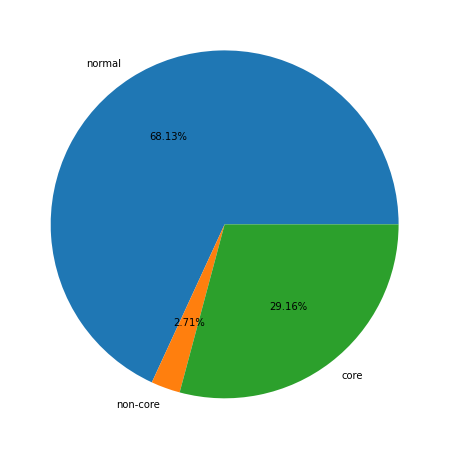

In [34]:
labels = ["normal", "non-core", "core"]
result_notubum = np.array(result_notubum)
result_ubum = np.array(result_ubum)

frequency = result_notubum+result_ubum

print(frequency)

fig = plt.figure(figsize=(8,8)) ## 캔버스 생성
fig.set_facecolor('white') ## 캔버스 색상 하얀색
 
ax = fig.add_subplot() ## 프레임 생성
 
ax.pie(x=frequency,labels=labels,autopct=lambda p : '{:.2f}%'.format(p)) ## 파이 차트 출력
plt.show()

In [41]:
sample_submission.to_csv('4차제출_재현.csv', encoding = 'utf-8', index =False)

In [36]:
sample_submission.head(25)

,신고번호,우범여부,핵심적발
0,982834,0,0
1,828961,0,0
2,522066,0,0
3,999547,0,0
4,919320,0,0
5,792304,0,0
6,778082,1,2
7,624568,0,0
8,649243,0,0
9,834543,0,0
